# Module 3 Final Project Submission

Please fill out:
* Student name: David Braslow
* Student pace: self paced 
* Scheduled project review date/time: 
* Instructor name: Eli
* Blog post URL: TBD
* Data source: https://www.kaggle.com/kevinarvai/clinvar-conflicting/version/3


# Overview

This project uses a Kaggle dataset to predict gene classifications. In this dataset, we are given multiple genetic variants and various properties of each. Expert raters at different laboratories rated these variants based on their perceived clinical classifications, with ratings ranging from Benign to Pathogenic. The target variable is whether the raters have clinical classifications that are concordant, meaning that they are in the same clinical category.  

## Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Obtaining the Data

For this project, I downloaded the dataset from the Kaggle page as a csv.

In [2]:
df = pd.read_csv('clinvar_conflicting.csv')
df.head()

C:\Users\david\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,...,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,955563,G,C,0.0000,0.00000,0.0000,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,11.390,1.133255,-2.0
1,1,955597,G,T,0.0000,0.42418,0.2826,MedGen:CN169374,NaN,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,8.150,0.599088,NaN
2,1,955619,G,C,0.0000,0.03475,0.0088,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,3.288,0.069819,1.0
3,1,957640,C,T,0.0318,0.02016,0.0328,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,12.560,1.356499,NaN
4,1,976059,C,T,0.0000,0.00022,0.0010,MedGen:CN169374,NaN,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,17.740,2.234711,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 46 columns):
CHROM                 65188 non-null object
POS                   65188 non-null int64
REF                   65188 non-null object
ALT                   65188 non-null object
AF_ESP                65188 non-null float64
AF_EXAC               65188 non-null float64
AF_TGP                65188 non-null float64
CLNDISDB              65188 non-null object
CLNDISDBINCL          76 non-null object
CLNDN                 65188 non-null object
CLNDNINCL             76 non-null object
CLNHGVS               65188 non-null object
CLNSIGINCL            76 non-null object
CLNVC                 65188 non-null object
CLNVI                 27659 non-null object
MC                    58219 non-null object
ORIGIN                59065 non-null float64
SSR                   104 non-null float64
CLASS                 65188 non-null int64
Allele                65188 non-null object
Consequence        

# Scrubbing the Data

There seem to be a number of feilds with missing data and incorrect types. In this section, I scrub the dataset squeaky-clean.

## Very Low Incidence Features

Here I drop features with under 600 entries (1% of dataset).

In [4]:
df = df.drop(['CLNDISDBINCL', 'CLNDNINCL', 'CLNSIGINCL', 'SSR', 'DISTANCE', 'MOTIF_NAME', 'MOTIF_POS', 'HIGH_INF_POS', 'MOTIF_SCORE_CHANGE'], axis = 1)

## Low Incidence Features

Here I dichotomize features that are present for less than half the dataset, 1 indicating that data are present, 0 otherwise.

In [5]:
for var in ['CLNVI', 'INTRON', 'BAM_EDIT', 'SIFT', 'PolyPhen', 'BLOSUM62']:
    df[var] = df[var].apply(lambda x: 1 if x == x else 0).astype('category')
    print(df[var].value_counts())

0    37529
1    27659
Name: CLNVI, dtype: int64
0    56385
1     8803
Name: INTRON, dtype: int64
0    33219
1    31969
Name: BAM_EDIT, dtype: int64
0    40352
1    24836
Name: SIFT, dtype: int64
0    40392
1    24796
Name: PolyPhen, dtype: int64
0    39595
1    25593
Name: BLOSUM62, dtype: int64


## Target: CLASS

The CLASS vartible is the target variable, which indicates whether there were conflicting submissions.

In [137]:
df = df.rename({'CLASS': 'target'}, axis = 1)
df['target'] = df['target'].astype('category')
df['target'].value_counts()

0    48754
1    16434
Name: target, dtype: int64

## CHROM

This variable captures the chromosome on which the variant is located. This should be a categorical variable.

In [7]:
df['CHROM'].value_counts()

2     8645
17    5394
11    4846
1     4454
19    3911
5     3643
7     2867
16    2771
12    2750
9     2744
13    2646
3     2529
10    2341
6     2159
14    1974
X     1926
8     1852
15    1725
4     1206
16    1156
22    1135
18     896
21     843
20     759
MT      16
Name: CHROM, dtype: int64

In [8]:
df['CHROM'] = df['CHROM'].astype('category')

## POS

This variable captures position of the gene on the chromosome. Will need to treat this with care in analysis, since it depends on CHROM.

In [9]:
df['POS'].describe()

count    6.518800e+04
mean     7.757594e+07
std      5.974051e+07
min      9.610000e+02
25%      3.254179e+07
50%      5.797021e+07
75%      1.127454e+08
max      2.476080e+08
Name: POS, dtype: float64

## REF, ALT, Allele

These variables are for capture variant alleles - should be categorical.

In [10]:
for var in ['REF', 'ALT', 'Allele']:
    print(df[var].value_counts()[0:10])

C     21798
G     21361
A      9845
T      9421
CT      126
GC      113
TG      105
AG      104
AC      103
GA       91
Name: REF, dtype: int64
T     20409
A     20205
G     11782
C     11429
TA      118
CT       93
CA       77
AT       75
GA       67
GT       64
Name: ALT, dtype: int64
T     19991
A     19800
G     11397
C     10761
-      2510
AA       46
TT       38
AT       20
CA       19
CT       17
Name: Allele, dtype: int64


There are a lot of low-frequency categories - I will lump them together into an "other" category.

In [11]:
for var in ['REF', 'ALT', 'Allele']:
    df[var] = df[var].apply(lambda x: 'O' if x not in ['A', 'C', 'G', 'T'] else x).astype('category')

## AF_ESP, AF_EXAC, and AF_TGP

These variables capture the allele frequency as found in other datasets. They are almost all zero, so I dichotomize them into zero vs non-zero.

In [12]:
df[['AF_ESP', 'AF_EXAC', 'AF_TGP']].describe()

,AF_ESP,AF_EXAC,AF_TGP
count,65188.000000,65188.000000,65188.000000
mean,0.014511,0.014492,0.015263
std,0.057795,0.059542,0.059527
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000040,0.000000
75%,0.001200,0.001230,0.001600
max,0.499000,0.499890,0.499800


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C282F14F28>,
      dtype=object)

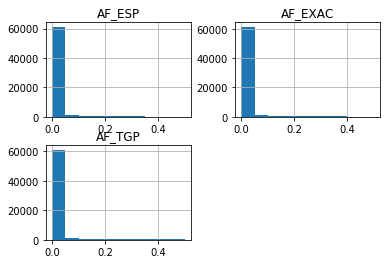

In [13]:
df[['AF_ESP', 'AF_EXAC', 'AF_TGP']].hist()

In [14]:
df['AF_ESP'] = df['AF_ESP'].apply(lambda x: 1 if x > 0 else 0).astype('category')
df['AF_EXAC'] = df['AF_EXAC'].apply(lambda x: 1 if x > 0 else 0).astype('category')
df['AF_TGP'] = df['AF_TGP'].apply(lambda x: 1 if x > 0 else 0).astype('category')

## CLNDISDB

This variable contains IDs for diseases in other databases. This variable has a large number of values, so it will be difficult to use it. I see that different values for this variable often contain the same identifiedrs, making the values arguable not unique (e.g. 'MedGen:CN169374' appears in multiple values). I choose to drop it.

In [15]:
print(len(df['CLNDISDB'].unique()))
df['CLNDISDB'].value_counts()[0:10]

9234


MedGen:CN169374                                                                                             5344
MedGen:C0027672,SNOMED_CT:699346009|MedGen:CN169374                                                         1724
MedGen:CN169374|MedGen:CN517202                                                                             1398
MedGen:C0027672,SNOMED_CT:699346009                                                                         1139
MedGen:C1837342,OMIM:608807,Orphanet:ORPHA140922|MedGen:C1858763,OMIM:604145|MedGen:CN169374                 913
MedGen:C0020445,OMIM:143890,SNOMED_CT:397915002,SNOMED_CT:398036000                                          732
MedGen:C0004135,OMIM:208900,Orphanet:ORPHA100,SNOMED_CT:68504005|MedGen:C0027672,SNOMED_CT:699346009         608
MedGen:C0027672,SNOMED_CT:699346009|MedGen:C0346153,OMIM:114480,Orphanet:ORPHA227535,SNOMED_CT:254843006     561
Human_Phenotype_Ontology:HP:0012265,MedGen:C0008780,Orphanet:ORPHA244|MedGen:CN169374           

In [16]:
df = df.drop('CLNDISDB', axis = 1)

## CLNDN

This captures the preferred disease name using the identifiers from CLNDISDB. This may be cleaner than the other variable, and is probably important for prediction, so I will attempt to clean it.

In [17]:
print(len(df['CLNDN'].unique()))
df['CLNDN'].value_counts()[0:20]

9260


not_specified                                                                                 5344
Hereditary_cancer-predisposing_syndrome|not_specified                                         1724
not_specified|not_provided                                                                    1398
Hereditary_cancer-predisposing_syndrome                                                       1139
Limb-girdle_muscular_dystrophy,_type_2J|Dilated_cardiomyopathy_1G|not_specified                913
Familial_hypercholesterolemia                                                                  732
Ataxia-telangiectasia_syndrome|Hereditary_cancer-predisposing_syndrome                         608
Hereditary_cancer-predisposing_syndrome|Familial_cancer_of_breast                              561
Ciliary_dyskinesia|not_specified                                                               526
Hereditary_cancer-predisposing_syndrome|Neurofibromatosis,_type_1                              513
Ataxia-tel

Each value is a list of diseases. It seems like I could clean this by creating dummy variables for specific common diseases in each list. I will create dummies for the top 100 diseases.

In [18]:
name_df = df['CLNDN'].str.split(pat = '|', expand = True)
name_df.head()
top_100_dn = name_df.apply(pd.value_counts).sum(axis=1).sort_values(ascending = False)[0:100]
print(top_100_dn[0:10])

top_100_dn_list = list(top_100_dn.index)
print(top_100_dn_list[0:10])

not_specified                                    45547.0
Hereditary_cancer-predisposing_syndrome          18367.0
not_provided                                     13020.0
Hereditary_breast_and_ovarian_cancer_syndrome     2058.0
Familial_cancer_of_breast                         1977.0
Dilated_cardiomyopathy_1G                         1951.0
Limb-girdle_muscular_dystrophy,_type_2J           1920.0
Cardiovascular_phenotype                          1853.0
Hypertrophic_cardiomyopathy                       1556.0
Ataxia-telangiectasia_syndrome                    1510.0
dtype: float64
['not_specified', 'Hereditary_cancer-predisposing_syndrome', 'not_provided', 'Hereditary_breast_and_ovarian_cancer_syndrome', 'Familial_cancer_of_breast', 'Dilated_cardiomyopathy_1G', 'Limb-girdle_muscular_dystrophy,_type_2J', 'Cardiovascular_phenotype', 'Hypertrophic_cardiomyopathy', 'Ataxia-telangiectasia_syndrome']


In [19]:
for dn in top_100_dn_list:
    df[dn] = df['CLNDN'].apply(lambda x: 1 if dn in x else 0).astype('category')
df = df.drop('CLNDN', axis = 1)

In [20]:
print(df.columns)

Index(['CHROM', 'POS', 'REF', 'ALT', 'AF_ESP', 'AF_EXAC', 'AF_TGP', 'CLNHGVS',
       'CLNVC', 'CLNVI',
       ...
       'Ehlers-Danlos_syndrome,_type_7A', 'Cardiomyopathy',
       'Congenital_contractural_arachnodactyly',
       'Cardiomyopathy_dilated_with_woolly_hair_and_keratoderma',
       'Romano-Ward_syndrome', 'Charcot-Marie-Tooth,_Type_4',
       'PTEN_hamartoma_tumor_syndrome', 'Nemaline_Myopathy,_Recessive',
       'Renal_cell_carcinoma,_papillary,_1', 'Hereditary_cutaneous_melanoma'],
      dtype='object', length=135)


## CLNHGVS

This variable is all unique values that I don't understand related to HGVS expression. I choose to drop it.

In [21]:
print(len(df['CLNHGVS'].unique()))
df = df.drop('CLNHGVS', axis = 1)

65188


## CLNVC

This variant type variable is almost all one value - I will turn it into a categorical variable by consolidating low-incidence types.

In [22]:
print(df['CLNVC'].value_counts())

single_nucleotide_variant    61281
Deletion                      2509
Duplication                   1034
Indel                          247
Insertion                       95
Inversion                       17
Microsatellite                   5
Name: CLNVC, dtype: int64


In [23]:
clnvc_types = ['single_nucleotide_variant', 'Deletion', 'Duplication']
df['CLNVC'] = df['CLNVC'].apply(lambda x: x if x in clnvc_types else 'Other').astype('category')

## MC

Molecular consequence is a categorical variable, need to clean up rare values. Since values are lists of consequences, I will do this similarly to how I did it for the names, splitting up the series and coding dummies.

In [24]:
df['MC'].value_counts()[0:10]

SO:0001583|missense_variant                                   23034
SO:0001819|synonymous_variant                                 16549
SO:0001627|intron_variant                                      7534
SO:0001583|missense_variant,SO:0001627|intron_variant          2422
SO:0001589|frameshift_variant                                  1622
SO:0001587|nonsense                                            1573
SO:0001627|intron_variant,SO:0001819|synonymous_variant        1148
SO:0001583|missense_variant,SO:0001623|5_prime_UTR_variant      599
SO:0001623|5_prime_UTR_variant                                  516
SO:0001575|splice_donor_variant                                 504
Name: MC, dtype: int64

In [25]:
name_df = df['MC'].str.split(pat = '[|,]', expand = True)
name_df.head()
top_mc = name_df.apply(pd.value_counts).sum(axis=1).sort_values(ascending = False)[0:20]
print(top_mc)

top_mc_list = [x for x in list(top_mc.index) if 'SO:' not in x]
print(top_mc_list)

missense_variant           26642.0
SO:0001583                 26642.0
synonymous_variant         18379.0
SO:0001819                 18379.0
intron_variant             11967.0
SO:0001627                 11967.0
5_prime_UTR_variant         1985.0
SO:0001623                  1985.0
SO:0001589                  1861.0
frameshift_variant          1861.0
nonsense                    1783.0
SO:0001587                  1783.0
3_prime_UTR_variant          704.0
SO:0001624                   704.0
splice_donor_variant         579.0
SO:0001575                   579.0
SO:0001636                   429.0
2KB_upstream_variant         429.0
SO:0001574                   428.0
splice_acceptor_variant      428.0
dtype: float64
['missense_variant', 'synonymous_variant', 'intron_variant', '5_prime_UTR_variant', 'frameshift_variant', 'nonsense', '3_prime_UTR_variant', 'splice_donor_variant', '2KB_upstream_variant', 'splice_acceptor_variant']


In [26]:
df['MC'] = df['MC'].fillna('unknown')
for mc in top_mc_list:
    df[mc] = df['MC'].apply(lambda x: 1 if mc in x else 0).astype('category')
    print(df[mc].value_counts())
df = df.drop('MC', axis = 1)

0    38546
1    26642
Name: missense_variant, dtype: int64
0    46809
1    18379
Name: synonymous_variant, dtype: int64
0    53221
1    11967
Name: intron_variant, dtype: int64
0    63203
1     1985
Name: 5_prime_UTR_variant, dtype: int64
0    63327
1     1861
Name: frameshift_variant, dtype: int64
0    63405
1     1783
Name: nonsense, dtype: int64
0    64484
1      704
Name: 3_prime_UTR_variant, dtype: int64
0    64609
1      579
Name: splice_donor_variant, dtype: int64
0    64759
1      429
Name: 2KB_upstream_variant, dtype: int64
0    64760
1      428
Name: splice_acceptor_variant, dtype: int64


## ORIGIN

Here is the description: "Allele origin. One or more of the following values may be added: 0 - unknown; 1 - germline; 2 - somatic; 4 - inherited; 8 - paternal; 16 - maternal; 32 - de-novo; 64 - biparental; 128 - uniparental; 256 - not-tested; 512 - tested-inconclusive; 1073741824 - other" Since almost all have origin 1 (germline), I will recode this to have 0 for all other values to make it a dummy variable.

In [27]:
df['ORIGIN'] = df['ORIGIN'].fillna(0).apply(lambda x: 1 if x == 1.0 else 0).astype('category')

## Consequence

This variable is similar to MC, but with slightly different values. I'm not sure why. I will use it to update the MC dummy variables from before.

In [28]:
name_df = df['Consequence'].str.split(pat = '&', expand = True)
name_df.head()
top_mc = name_df.apply(pd.value_counts).sum(axis=1).sort_values(ascending = False)
print(top_mc[0:20])

missense_variant            32408.0
synonymous_variant          18220.0
intron_variant               7847.0
splice_region_variant        5065.0
frameshift_variant           1864.0
stop_gained                  1800.0
5_prime_UTR_variant           642.0
inframe_deletion              593.0
splice_donor_variant          584.0
3_prime_UTR_variant           435.0
splice_acceptor_variant       421.0
inframe_insertion             204.0
start_lost                    100.0
upstream_gene_variant          82.0
coding_sequence_variant        43.0
downstream_gene_variant        26.0
stop_lost                      16.0
intergenic_variant             14.0
stop_retained_variant          12.0
protein_altering_variant       10.0
dtype: float64


In [29]:
for mc in top_mc_list:
    mc2 = mc + '2'
    df[mc2] = df['Consequence'].apply(lambda x: 1 if mc in x else 0).astype('category')
    df[mc] = df[[mc, mc2]].apply(lambda x: max(x[mc], x[mc2]), axis = 1).astype('category')
    print(df[mc].value_counts())
    df=df.drop(mc2, axis = 1)
df = df.drop('Consequence', axis = 1)

1    32783
0    32405
Name: missense_variant, dtype: int64
0    46770
1    18418
Name: synonymous_variant, dtype: int64
0    53145
1    12043
Name: intron_variant, dtype: int64
0    63132
1     2056
Name: 5_prime_UTR_variant, dtype: int64
0    63301
1     1887
Name: frameshift_variant, dtype: int64
0    63405
1     1783
Name: nonsense, dtype: int64
0    64431
1      757
Name: 3_prime_UTR_variant, dtype: int64
0    64568
1      620
Name: splice_donor_variant, dtype: int64
0    64759
1      429
Name: 2KB_upstream_variant, dtype: int64
0    64741
1      447
Name: splice_acceptor_variant, dtype: int64


## IMPACT

Categorical variable capturing variant impact

In [30]:
df['IMPACT'].value_counts()

MODERATE    33212
LOW         21642
MODIFIER     5582
HIGH         4752
Name: IMPACT, dtype: int64

In [31]:
df['IMPACT'] = df['IMPACT'].astype('category')

## SYMBOL

This variable is the Gene symbol/ID. It has many values - I will make it categorical, but only keep the top 100 values, recoding the rest as "Other".

In [32]:
len(df['SYMBOL'].unique())

2329

In [33]:
df['SYMBOL'].value_counts()[0:10]

TTN      2765
BRCA2    1934
ATM      1909
APC      1228
BRCA1    1075
MSH6     1048
LDLR      905
PALB2     794
NF1       732
TSC2      640
Name: SYMBOL, dtype: int64

In [34]:
top_100_symb = df['SYMBOL'].value_counts()[0:100].index
df['SYMBOL'] = df['SYMBOL'].apply(lambda x: x if x in top_100_symb else 'Other').astype('category')

In [35]:
df['SYMBOL'].value_counts()[0:100]

Other      30800
TTN         2765
BRCA2       1934
ATM         1909
APC         1228
BRCA1       1075
MSH6        1048
LDLR         905
PALB2        794
NF1          732
TSC2         640
BRIP1        627
PMS2         600
MSH2         596
POLE         571
CDH1         553
CHEK2        491
BARD1        490
SMARCA4      451
MYBPC3       441
RAD50        426
SYNE1        422
TP53         420
POLD1        404
NBN          397
MLH1         395
MUTYH        391
PLEC         379
STK11        359
MYH7         333
           ...  
KCNH2        151
LAMA2        151
CACNA1C      150
ASPM         148
PCNT         146
SMAD4        146
MEN1         143
FLNA         141
ABCA4        138
MECP2        136
BAP1         135
PKP2         132
FLCN         131
MYO7A        131
BLM          129
APOB         128
MET          126
VHL          126
ATP7B        126
WFS1         126
DYNC1H1      124
CDKN2A       124
KMT2D        123
FANCC        123
RELN         123
CNTNAP2      123
VPS13B       121
FH           1

## Feature

This is an ID associated with gene name - deleting due to redundancy

In [36]:
df = df.drop('Feature', axis = 1)

## Feature_type and BIOTYPE

These features have little information (almost all records have same value), so I drop them.

In [37]:
for var in ['Feature_type', 'BIOTYPE']:
    print(df[var].value_counts())
    df = df.drop(var, axis = 1)

Transcript      65172
MotifFeature        2
Name: Feature_type, dtype: int64
protein_coding    65158
misc_RNA             14
Name: BIOTYPE, dtype: int64


## EXON

This captures the relative exon number. Given the very large numbers of unique values, I choose to drop it.

In [38]:
len(df['EXON'].unique())

3265

In [39]:
df = df.drop('EXON', axis = 1)

## cDNA_position, CDS_position, Protein_position

These represent relative positions of the base pair in various ways. These are all distance measures, which I think are irrelevant to the problem at hand, and difficult to clean so I drop them.

In [40]:
df = df.drop(['cDNA_position', 'CDS_position', 'Protein_position'], axis = 1)

## Amino_acids, Codons

These have a large number of unique values, so I drop them.

In [41]:
df = df.drop(['Amino_acids', 'Codons'], axis = 1)

## STRAND

Categorical: defined as + (forward) or - (reverse)

In [42]:
df['STRAND'].value_counts()

-1.0    32804
 1.0    32370
Name: STRAND, dtype: int64

In [60]:
df['STRAND'] = df['STRAND'].fillna(df['STRAND'].mode())
df['STRAND'] = df['STRAND'].astype('category')

## LoFtool

Numeric variable: Loss of Function tolerance score for loss of function variants. Will fill missing values with median.

In [61]:
df['LoFtool'] = df['LoFtool'].fillna(df['LoFtool'].median())

## CADD_PHRED, CADD_RAW

Different scores of deleteriousness - I keep them and fill missing values with medians.

In [62]:
df['CADD_PHRED'] = df['CADD_PHRED'].fillna(df['CADD_PHRED'].median())

In [63]:
df['CADD_RAW'] = df['CADD_RAW'].fillna(df['CADD_RAW'].median())

## Scaling numeric variables

In [100]:
from sklearn.preprocessing import StandardScaler

num_var_list = ['POS', 'LoFtool', 'CADD_PHRED', 'CADD_RAW']
scl = StandardScaler()
df[num_var_list] = scl.fit_transform(df[num_var_list])

## Separate target and features

In [147]:
target = df['target']
features = df.drop('target', axis = 1)

# Exploring the Data

In [148]:
#Original columns
list(df.columns[0:23])

['CHROM',
 'POS',
 'REF',
 'ALT',
 'AF_ESP',
 'AF_EXAC',
 'AF_TGP',
 'CLNVC',
 'CLNVI',
 'ORIGIN',
 'target',
 'Allele',
 'IMPACT',
 'SYMBOL',
 'INTRON',
 'STRAND',
 'BAM_EDIT',
 'SIFT',
 'PolyPhen',
 'LoFtool',
 'CADD_PHRED',
 'CADD_RAW',
 'BLOSUM62']

In [149]:
df.iloc[:, 0:23].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 23 columns):
CHROM         65188 non-null category
POS           65188 non-null float64
REF           65188 non-null category
ALT           65188 non-null category
AF_ESP        65188 non-null category
AF_EXAC       65188 non-null category
AF_TGP        65188 non-null category
CLNVC         65188 non-null category
CLNVI         65188 non-null category
ORIGIN        65188 non-null category
target        65188 non-null category
Allele        65188 non-null category
IMPACT        65188 non-null category
SYMBOL        65188 non-null category
INTRON        65188 non-null category
STRAND        65174 non-null category
BAM_EDIT      65188 non-null category
SIFT          65188 non-null category
PolyPhen      65188 non-null category
LoFtool       65188 non-null float64
CADD_PHRED    65188 non-null float64
CADD_RAW      65188 non-null float64
BLOSUM62      65188 non-null category
dtypes: category(19),

In [150]:
#Original feature set
orig_feat = list(features.columns[0:22])
orig_feat_cat = [x for x in orig_feat if x not in num_var_list]

## Numeric Variables

In this section I explore the numeric variables in the dataset. I find that there is a high correlation between CADD_PHRED and CADD_RAW, so I choose to drop one of them. I drop CADD_RAW due to the long right tail.

In [151]:
features[num_var_list].describe()

,POS,LoFtool,CADD_PHRED,CADD_RAW
count,6.518800e+04,6.518800e+04,6.518800e+04,6.518800e+04
mean,2.678702e-15,-1.120352e-14,4.172959e-17,8.046341e-17
std,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00
min,-1.298542e+00,-9.444451e-01,-1.456945e+00,-2.727595e+00
25%,-7.538351e-01,-8.580947e-01,-7.774106e-01,-6.993341e-01
50%,-3.281839e-01,-4.991418e-01,-1.459828e-01,-3.048435e-01
75%,5.887084e-01,9.168069e-01,7.761289e-01,6.039678e-01
max,2.846198e+00,1.892932e+00,7.754774e+00,1.497726e+01


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C28BE3ADD8>,
      dtype=object)

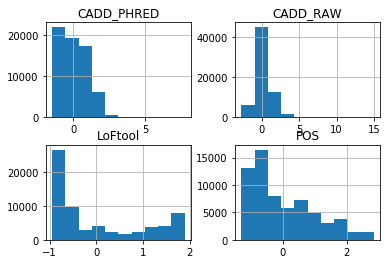

In [152]:
features[num_var_list].hist()

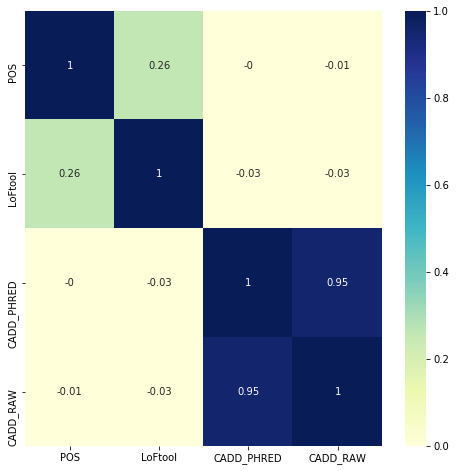

In [153]:
plt.figure(figsize=(8,8))
sns.heatmap(features[num_var_list].corr(),
            vmin=0,
            vmax=1,
            cmap='YlGnBu',
            annot=np.round(features[num_var_list].corr(), 2))

In [154]:
features = features.drop('CADD_RAW', axis = 1)

# Categorical Variables

Associations between categorical variables can be difficult to visualize. I use Cramer's V to understand the associations between each pair of categorical features, adapting this code: https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

In [155]:
import scipy.stats as ss

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [156]:
num_feat = len(orig_feat_cat)
cat_corr_arr = np.empty((num_feat, num_feat))
for i, row in enumerate(orig_feat_cat):
    for j, col in enumerate(orig_feat_cat):
        #print((i, j))
        cat_corr_arr[i, j] = cramers_v(features[row], features[col])
print(cat_corr_arr[0:5, 0:5])

[[1.         0.07279856 0.05874832 0.19748628 0.17758803]
 [0.07279856 1.         0.54794936 0.17637193 0.18513339]
 [0.05874832 0.54794936 1.         0.14589897 0.19605855]
 [0.19748628 0.17637193 0.14589897 0.99996902 0.65171702]
 [0.17758803 0.18513339 0.19605855 0.65171702 0.99996705]]


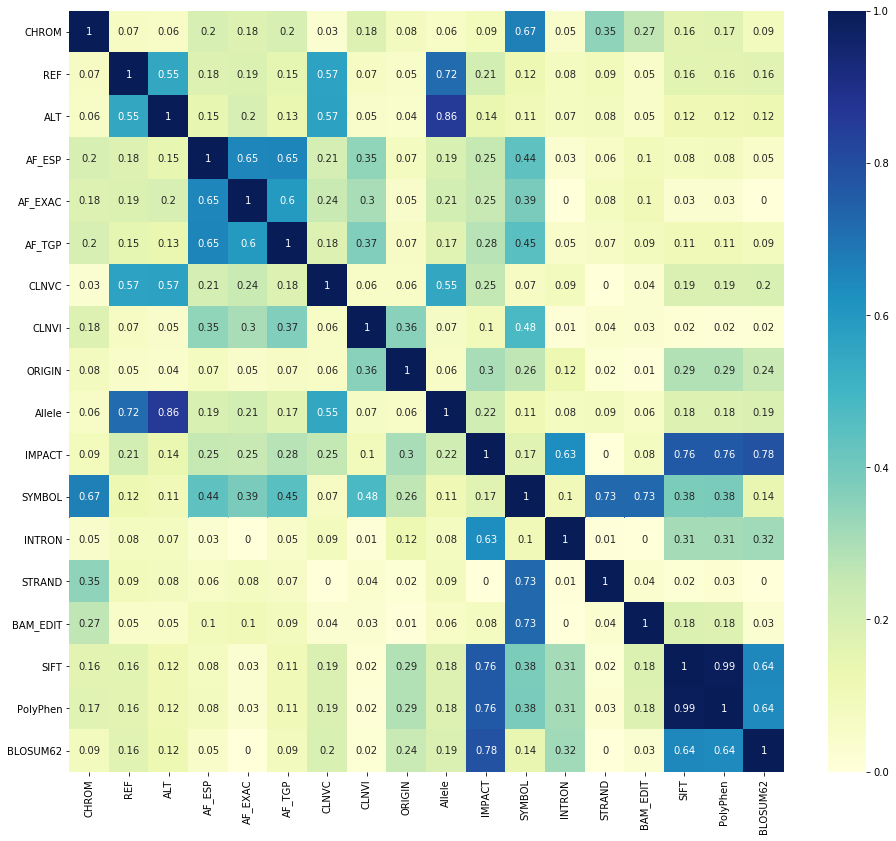

In [157]:
plt.figure(figsize=(16, 14))
sns.heatmap(cat_corr_arr,
            vmin=0,
            vmax=1,
            cmap='YlGnBu',
            xticklabels = orig_feat_cat,
            yticklabels = orig_feat_cat,
            annot=np.round(cat_corr_arr, 2))

I choose to drop the Allele, IMPACT, SYMBOL and PolyPhen variables due to high correlations.

In [158]:
features = features.drop(['Allele', 'IMPACT', 'SYMBOL', 'PolyPhen'], axis = 1)

# Modeling

For this problem, I choose to use multiple classifiers to see how they compare. I start with a dummy classifier as a baseline for comparison. Then I proceed to Random Forest Classifier, Naive Bayes, and AdaBoost. I will test the effects of various parameter spefications on model performance.

In [171]:
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score

In [160]:
features = pd.get_dummies(features, drop_first = True)

## Dummy

In [169]:
dm_clf = DummyClassifier(random_state = 42)
mean_dm_cv_score = cross_val_score(dm_clf, features, target, cv = 3).mean()
print("Mean Cross Validation Score for Dummy Classifier: {:.4}%".format(mean_dm_cv_score * 100))

Mean Cross Validation Score for Dummy Classifier: 62.33%


## Naive Bayes

Another classifier

In [170]:
nb_clf = GaussianNB()
mean_nb_cv_score = cross_val_score(nb_clf, features, target, cv = 3).mean()
print("Mean Cross Validation Score for Naive Bayes Classifier: {:.4}%".format(mean_nb_cv_score * 100))

Mean Cross Validation Score for Naive Bayes Classifier: 67.79%


## Random Forest

In [161]:
rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 42, oob_score = True)
mean_rf_cv_score = cross_val_score(rf_clf, features, target, cv = 3).mean()
print("Mean Cross Validation Score for Random Forest Classifier: {:.4}%".format(mean_rf_cv_score * 100))

rf_clf.fit(features, target)
print("Mean Out-of-Bag Score for Random Forest Classifier: {:.4}%".format(rf_clf.oob_score_ * 100))

Mean Cross Validation Score for Random Forest Classifier: 75.13%
Mean Out-of-Bag Score for Random Forest Classifier: 76.7%


In [162]:
rf_param_grid = {
'n_estimators': [50, 100, 200],
'criterion': ['gini', 'entropy'],
'max_depth': [5, 10, None] ,
'min_samples_split': [5, 10]  ,     
'min_samples_leaf': [3, 6]
}

In [164]:
import time
start = time.time()
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv = 3)
rf_grid_search.fit( features, target)

print("Testing Accuracy: {:.4}%".format(rf_grid_search.best_score_ * 100))
print("Total Runtime for Grid Search on Random Forest Classifier: {:.4} seconds".format(time.time() - start))
print("")
print("Optimal Parameters: {}".format(rf_grid_search.best_params_))

Testing Accuracy: 75.27%
Total Runtime for Grid Search on Random Forest Classifier: 1.903e+03 seconds

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}


Using Random Search approach from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [165]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [167]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(features, target)

print("Testing Accuracy: {:.4}%".format(rf_random.best_score_ * 100))
print("Total Runtime for Grid Search on Random Forest Classifier: {:.4} seconds".format(time.time() - start))
print("")
print("Optimal Parameters: {}".format(rf_random.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 73.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 131.6min finished


Testing Accuracy: 75.45%
Total Runtime for Grid Search on Random Forest Classifier: 1.085e+04 seconds

Optimal Parameters: {'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}


In [ ]:
def plot_feature_importances(model):
    n_features = data_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), data_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

In [ ]:
rf_tree_1 = forest_2.estimators_[0]
plot_feature_importances(rf_tree_1)

## AdaBoost

In [173]:
adb_clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(), random_state = 42)
mean_adb_cv_score = cross_val_score(adb_clf, features, target, cv = 3).mean()
print("Mean Cross Validation Score for AdaBoost Decision Tree Classifier: {:.4}%".format(mean_adb_cv_score * 100))

Mean Cross Validation Score for AdaBoost Decision Tree Classifier: 70.07%
